# Simulation-based Calibration in SBI

After a posterior has been trained given a simulation, predictions from this posterior should be made subject to several diagnostical tests. [Posterior Predictive Checks](12_diagnosis_posterior_predictive_check.ipynb) are one such way to "critique" a trained model. Another important approach to such diagnostics is simulation-based calibration as reported by [Talts et al, 2018](https://arxiv.org/abs/1804.06788).

**Simulation-based calibration** (SBC) boils down to a visual (qualitative) way as well as a quantitive measure to check, if the uncertainties obtained from the ensemble of posterior samples meets expectations. In this way, SBC can unveil if the uncertainties of the posterior samples can be considered well calibrated (or healthy if you will). SBC can be used to uncover malignant posteriors. SBC cannot be used to fix this posterior. As such, SBC can be viewed as a necessary condition for a valid inference using a posterior.

## in a nutshell

SBC repeats posterior inference to obtain predicted samples of $x_{true}$ (obtained from $simulator(\theta_{true})$). SBC then ranks these $\theta_{pp}$ with respect to $\theta_{true}$. This rank is calculated by counting those samples $\theta_{pp}$ which fall below $\theta_{true}$. 

### key ideas behind SBC

The core idea behind SBC is two fold: 

- SBC ranks of posterior samples with respect to their ground truth follow a uniform distribution.  
(If the SBC ranks are not uniformly distributed, the posterior is not well calibrated.)

- samples from the data averaged posterior are distributed according to the prior

### What can SBC diagnose?

**SBC can inform us whether we are not wrong.** However, it cannot tell us whether we are right. SBC checks a necessary condition. For example, imagine you run SBC using the prior as a posterior. The ranks would be perfectly uniform. But the inference would be wrong.

**The [Posterior Predictive Checks](12_diagnosis_posterior_predictive_check.ipynb) can be seen as the complementary sufficient check** for the posterior (only as a methaphor, no theoretical guarantees here). Using the prior as a posterior and then doing predictive checks would clearly show that inference failed. 

So SBC can ...

- tell us whether a method produces posterior samples $\theta_{pp}$ that have a systematic negative or positive bias (shift in the mean of the predictions)
- tell us whether a method produces posterior samples $\theta_{pp}$ that are systematically over- or underdispersed (too large or too small variance) 

## a healthy posterior

Let's take the gaussian linear simulation and run inference with (S)NPE on it. As we do not perform any rounds, we actually only do neural posterior estimation (NPE).

In [1]:
import torch
_ = torch.manual_seed(10)
from torch import eye, ones, zeros
from torch.distributions import MultivariateNormal

from sbi.analysis import check_sbc, run_sbc, get_nltp
from sbi.inference import SNPE, SNPE_C, prepare_for_sbi, simulate_for_sbi
from sbi.simulators import linear_gaussian, diagonal_linear_gaussian


In [2]:
num_dim = 2
num_simulations = 5_000

prior_mean = ones(num_dim)
prior_cov = 2*eye(num_dim)
prior = MultivariateNormal(loc=prior_mean, covariance_matrix=prior_cov, validate_args=False)


## An ideal case

To explore SBC, we make our life easy and assume that we deal with a problem where the likelihood is modelled by an identity mapping and a bit of smear. But to start, we only use an almost vanishing smear of `0.01`.

In [3]:

default_likelihood_loc = 0. #let's start with 0 shift
default_likelihood_scale = 0.01 #let's smear theta only by a little bit

def simulator(theta, loc = default_likelihood_loc, scale = default_likelihood_scale):
    """ linear gaussian inspired by sbibm
    s://github.com/sbi-benchmark/sbibm/blob/15f068a08a938383116ffd92b92de50c580810a3/sbibm/tasks/gaussian_linear/task.py#L74
    """
    num_dim = theta.shape[-1]
    cov_ = scale*eye(num_dim) #always positively semi-definite

    # using validate_args=False disables sanity checks on `covariance_matrix`
    # for the sake of speed
    value = MultivariateNormal(loc=(theta+loc), covariance_matrix=cov_, validate_args=False).sample()
    return value

simulator, prior = prepare_for_sbi(simulator, prior)
theta, x = simulate_for_sbi(simulator, prior, num_simulations)


Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

In [4]:
# we define a hold-out sample of 100 to build an observation
theta_holdout = prior.sample((100,))
x_holdout = simulator(theta_holdout)

theta_o = theta_holdout[42,]
x_o = simulator(theta_o)
print("theta:", theta_o.numpy())
print("x    :", x_o.numpy())

theta: [0.68821174 4.186863  ]
x    : [0.69967127 4.3175235 ]


In [5]:
from sbi.utils.get_nn_models import posterior_nn

#we use a mdn model to have a fast turnaround with training
defn = posterior_nn(model='mdn')
inferer = SNPE(prior, density_estimator=defn)

# let's not save the density_estimator in order to do NPE
# (we have enough simulations)
_ = inferer.append_simulations(theta, x).train()

 Training neural network. Epochs trained:  1

 Training neural network. Epochs trained:  2

 Training neural network. Epochs trained:  3

 Training neural network. Epochs trained:  4

 Training neural network. Epochs trained:  5

 Training neural network. Epochs trained:  6

 Training neural network. Epochs trained:  7

 Training neural network. Epochs trained:  8

 Training neural network. Epochs trained:  9

 Training neural network. Epochs trained:  10

 Training neural network. Epochs trained:  11

 Training neural network. Epochs trained:  12

 Training neural network. Epochs trained:  13

 Training neural network. Epochs trained:  14

 Training neural network. Epochs trained:  15

 Training neural network. Epochs trained:  16

 Training neural network. Epochs trained:  17

 Training neural network. Epochs trained:  18

 Training neural network. Epochs trained:  19

 Training neural network. Epochs trained:  20

 Training neural network. Epochs trained:  21

 Training neural network. Epochs trained:  22

 Training neural network. Epochs trained:  23

 Training neural network. Epochs trained:  24

 Training neural network. Epochs trained:  25

 Training neural network. Epochs trained:  26

 Training neural network. Epochs trained:  27

 Training neural network. Epochs trained:  28

 Training neural network. Epochs trained:  29

 Training neural network. Epochs trained:  30

 Training neural network. Epochs trained:  31

 Training neural network. Epochs trained:  32

 Training neural network. Epochs trained:  33

 Training neural network. Epochs trained:  34

 Training neural network. Epochs trained:  35

 Training neural network. Epochs trained:  36

 Training neural network. Epochs trained:  37

 Training neural network. Epochs trained:  38

 Training neural network. Epochs trained:  39

 Training neural network. Epochs trained:  40

 Training neural network. Epochs trained:  41

 Training neural network. Epochs trained:  42

 Training neural network. Epochs trained:  43

 Training neural network. Epochs trained:  44

 Training neural network. Epochs trained:  45

 Training neural network. Epochs trained:  46

 Training neural network. Epochs trained:  47

 Training neural network. Epochs trained:  48

 Training neural network. Epochs trained:  49

 Training neural network. Epochs trained:  50

 Training neural network. Epochs trained:  51

 Training neural network. Epochs trained:  52

 Training neural network. Epochs trained:  53

 Training neural network. Epochs trained:  54

 Training neural network. Epochs trained:  55

 Training neural network. Epochs trained:  56

 Training neural network. Epochs trained:  57

 Training neural network. Epochs trained:  58

 Training neural network. Epochs trained:  59

 Training neural network. Epochs trained:  60

 Training neural network. Epochs trained:  61

 Training neural network. Epochs trained:  62

 Training neural network. Epochs trained:  63

 Training neural network. Epochs trained:  64

 Training neural network. Epochs trained:  65

 Training neural network. Epochs trained:  66

 Training neural network. Epochs trained:  67

 Training neural network. Epochs trained:  68

 Training neural network. Epochs trained:  69

 Training neural network. Epochs trained:  70

 Training neural network. Epochs trained:  71

 Training neural network. Epochs trained:  72

 Training neural network. Epochs trained:  73

 Training neural network. Epochs trained:  74

 Training neural network. Epochs trained:  75

 Training neural network. Epochs trained:  76

 Training neural network. Epochs trained:  77

 Training neural network. Epochs trained:  78

 Training neural network. Epochs trained:  79

 Training neural network. Epochs trained:  80

 Training neural network. Epochs trained:  81

 Training neural network. Epochs trained:  82

 Training neural network. Epochs trained:  83

 Training neural network. Epochs trained:  84

 Training neural network. Epochs trained:  85

 Training neural network. Epochs trained:  86

 Training neural network. Epochs trained:  87

 Training neural network. Epochs trained:  88

 Training neural network. Epochs trained:  89

 Training neural network. Epochs trained:  90

 Training neural network. Epochs trained:  91

 Training neural network. Epochs trained:  92

 Training neural network. Epochs trained:  93

 Training neural network. Epochs trained:  94

 Training neural network. Epochs trained:  95

 Training neural network. Epochs trained:  96

 Training neural network. Epochs trained:  97

 Training neural network. Epochs trained:  98

 Training neural network. Epochs trained:  99

 Training neural network. Epochs trained:  100

 Training neural network. Epochs trained:  101

 Training neural network. Epochs trained:  102

 Training neural network. Epochs trained:  103

 Training neural network. Epochs trained:  104

 Training neural network. Epochs trained:  105

 Training neural network. Epochs trained:  106

 Training neural network. Epochs trained:  107

 Training neural network. Epochs trained:  108

 Training neural network. Epochs trained:  109

 Training neural network. Epochs trained:  110

 Training neural network. Epochs trained:  111

 Training neural network. Epochs trained:  112

 Training neural network. Epochs trained:  113

 Training neural network. Epochs trained:  114

 Training neural network. Epochs trained:  115

 Training neural network. Epochs trained:  116

 Training neural network. Epochs trained:  117

 Training neural network. Epochs trained:  118

 Training neural network. Epochs trained:  119

 Training neural network. Epochs trained:  120

 Training neural network. Epochs trained:  121

 Training neural network. Epochs trained:  122

 Training neural network. Epochs trained:  123

 Training neural network. Epochs trained:  124

 Training neural network. Epochs trained:  125

 Training neural network. Epochs trained:  126

 Training neural network. Epochs trained:  127Neural network successfully converged after 127 epochs.


In [6]:
posterior = inferer.build_posterior()
posterior_samples = posterior.sample((15_000,), x = x_o).detach()
posterior_data = simulator(posterior_samples)


Drawing 15000 posterior samples:   0%|          | 0/15000 [00:00<?, ?it/s]

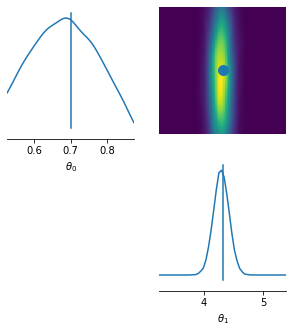

In [7]:
#let's do some posterior predictive checks to see if the
#observation `x_o` remains within the support of the posterior
from sbi.analysis import pairplot

fig, ax = pairplot(
    samples=posterior_data,
    points=x_o,
    limits=list(zip(.75*x_o.flatten(), 1.25*x_o.flatten())),
    upper=['kde'],
    diag=['kde'],
    figsize=(5,5),
    labels=[rf"$\theta_{d}$" for d in range(3)]
)

The posterior is well aligned with the observation. On top, the observation falls into the support of the posterior samples. That is indicative that our posterior estimate matches the true posterior very well.

### Running SBC

We have a working and trained posterior at this point! Hurray! Let's look at the SBC metrics now.

In [8]:
num_sbc_runs = 1_000 #the higher sbc runs the better
thetas = prior.sample((num_sbc_runs,)) #we sample again from the prior (as an alternative, we could have used our holdout set)
xs = simulator(thetas) 

In [9]:
ranks, dap_samples = run_sbc(thetas, xs, posterior, num_workers=1)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

`sbi` has established two methods to do simulation-based calibration:

- metrics to compare the sbc ranks with a uniform distribution 
- control plots for visual inspections like fig. 1 or 2 in [Talts et al, 2018](https://arxiv.org/abs/1804.06788)

The `ranks` count per dimension of `theta` how many posterior samples fall below `theta_o`. Based on theory, the distribution of these ranks per dimension of `theta` should turn out to be uniformly distributed. 

The data average posterior `dap` (see equation 1 of [Talts et al, 2018](https://arxiv.org/abs/1804.06788)) is yet another metric of interest. It contains one sample from the estimated posterior obtained from the `xs` above. The `dap` is expected to match the prior distribution used.

In [10]:
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)

The `check_stats` variable created contains a dictionary with 3 metrics that help to judge our posterior. The "first" two compare the ranks to a uniform distribution.

### Ranks versus Uniform distribution

In [11]:
print(f"- kolmogorov-smirnov p-values \n  check_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}")
print(f"- c2st accuracies \n  check_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}")

- kolmogorov-smirnov p-values 
  check_stats['ks_pvals'] = [0.3626923  0.01928918]
- c2st accuracies 
  check_stats['c2st_ranks'] = [0.571  0.5735]


The Kolmogorov-Smirnov (KS test, see also [here](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Two-sample_Kolmogorov%E2%80%93Smirnov_test)) provides a p-value under the null hypothesis that the samples from `ranks` are drawn from a uniform distribution. We are provided two values as our problem is two-dimensional. As we are provided high values of this statistic, both samples appear to be from the same distribution. 

The second tier of metrics comparing `ranks` with a uniform distributions is a `c2st` test (see [here](http://arxiv.org/abs/1610.06545) for details). This is a nonparametric two sample test based on training a classifier to differented one of the ensembles by being trained on the others. The values reported are the accuracies from cross-validation. If you see values around `0.5`, the classifier was unable to differentiate both samples, i.e. `ranks` are very uniform. If the values are very high towards `1`, this represents the case where `ranks` is very unlike a uniform distribution.

### Data averaged posterior (DAP) versus prior

In [12]:
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")

- c2st accuracies check_stats['c2st_dap'] = [0.492 0.479]


The last metric reported is again based on `c2st` computed per dimension of `theta`. If you see values around `0.5`, the `c2st` classifier was unable to differentiate both samples, i.e. `dap` are much (if not identical to) the prior. If the values are very high towards `1`, this represents the case where `dap` is very unlike the prior distribution.

### Visual Inspection

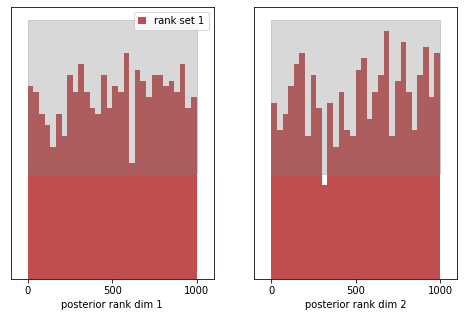

In [13]:
from sbi.analysis.plot import sbc_rank_plot

f, ax = sbc_rank_plot(ranks, 1_000, plot_type = "hist", num_bins=30)

The two plots show only visualize the histogram across the `ranks` (here depicted in red). Highlighted in grey is the 95% confidence interval of a uniform distribution given the number of samples provided. In plain english, the majority of red bars should reach the grey area of the confidence interval.

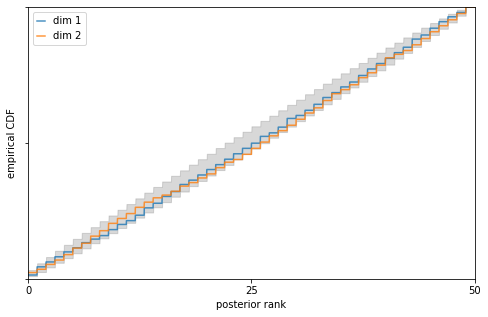

In [14]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type = "cdf")

The above provides a visual representation of the cumulative density function (CDF) of `ranks` (blue and orange for each dimension of `theta`) with respect to the 95% confidence interval of a uniform distribution (grey).

# When things go haywire

Next, we would like to explore some pathologies visible in sbc plots which can hint at our estimated posterior being somewhat wrong or completely off.

## shifted mean

In this scenario we emulate the situation that our posterior go the location of the postior incorrect by reusing our trained NPE posterior from above, but providing a simulator that shifts the expectation value of the likelihood.

In [17]:
posterior_off = MultivariateNormal(loc=prior_mean+2, covariance_matrix=prior_cov+default_likelihood_scale, validate_args=False)


In [18]:
ranks, dap_samples = run_sbc(thetas, xs, posterior, num_workers=1)
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)
print(check_stats)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/steinb95/development/sbi/venv-current-cpy39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/steinb95/development/sbi/venv-current-cpy39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/steinb95/development/sbi/venv-current-cpy39/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 327, in fit
    X, y = self._validate_data(
  File "/home/steinb95/development/sbi/venv-current-cpy39/lib/python3.9/site-p

{'ks_pvals': tensor([0., 0.]), 'c2st_ranks': tensor([nan, nan]), 'c2st_dap': tensor([0.6735, 0.6940])}
